In [1]:
# Chroma Change Embeddings Analysis
# Analysis of extracted embeddings from chroma_change dataset

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("Libraries imported successfully!")


Libraries imported successfully!


In [ ]:
# Load embeddings and metadata
embeddings_dir = Path("data/embeddings/qwen2.5_7B/describe_color/munsell_colors")
dataset_manifest_path = Path("data/colors/munsell_colors/munsell_manifest.csv")

# Load dataset manifest for color information
dataset_manifest = pd.read_csv(dataset_manifest_path)

print(f"Loaded metadata")

Loaded metadata


In [ ]:
# Load embeddings and metadata
embeddings_dir = Path("data/embeddings/qwen2.5_7B/chroma_change")
dataset_manifest_path = Path("data/colors/chroma_change/manifest.json")

# Load dataset manifest for color information
with open(dataset_manifest_path, 'r') as f:
    dataset_manifest = json.load(f)

# Create mapping from index to color metadata
index_to_color = {}
for chain in dataset_manifest['chains']:
    for item in chain['items']:
        idx = str(item['index'])
        index_to_color[idx] = {
            'notation': item['notation'],
            'xyY': item['xyY'],
            'H': item['H'],
            'C': item['C'],
            'V': item['V'],
            'chain_description': chain['description']
        }

print(f"Loaded metadata for {len(index_to_color)} color samples")
print("Sample color data:")
for i in range(1, 6):
    if str(i) in index_to_color:
        print(f"  {i}: {index_to_color[str(i)]['notation']} - {index_to_color[str(i)]['chain_description']}")


In [3]:
# Load all embeddings
def load_embeddings(embeddings_dir):
    """Load all embedding files and return organized data"""
    embeddings_data = {
        'lm_pooled_mean': [],
        'vision_pooled_mean': [],
        'visual_token_lens': [],
        'indices': [],
        'metadata': []
    }
    
    # Get all subdirectories (numbered folders)
    subdirs = sorted([d for d in embeddings_dir.iterdir() if d.is_dir() and d.name.isdigit()])
    
    for subdir in subdirs:
        idx = subdir.name
        
        # Load manifest for metadata
        manifest_path = subdir / 'manifest.json'
        if manifest_path.exists():
            with open(manifest_path, 'r') as f:
                manifest = json.load(f)
            embeddings_data['metadata'].append(manifest)
        else:
            embeddings_data['metadata'].append({})
        
        # Load embeddings
        lm_path = subdir / 'lm_pooled_mean.npy'
        vision_path = subdir / 'vision_pooled_mean.npy'
        lens_path = subdir / 'visual_token_lens.npy'
        
        if lm_path.exists():
            lm_emb = np.load(lm_path)
            embeddings_data['lm_pooled_mean'].append(lm_emb.flatten())
        else:
            embeddings_data['lm_pooled_mean'].append(None)
            
        if vision_path.exists():
            vision_emb = np.load(vision_path)
            embeddings_data['vision_pooled_mean'].append(vision_emb.flatten())
        else:
            embeddings_data['vision_pooled_mean'].append(None)
            
        if lens_path.exists():
            lens_emb = np.load(lens_path)
            embeddings_data['visual_token_lens'].append(lens_emb.flatten())
        else:
            embeddings_data['visual_token_lens'].append(None)
            
        embeddings_data['indices'].append(idx)
    
    return embeddings_data

# Load the data
embeddings_data = load_embeddings(embeddings_dir)
print(f"Loaded embeddings for {len(embeddings_data['indices'])} samples")

# Check embedding shapes
for emb_type in ['lm_pooled_mean', 'vision_pooled_mean', 'visual_token_lens']:
    valid_embs = [emb for emb in embeddings_data[emb_type] if emb is not None]
    if valid_embs:
        print(f"{emb_type}: {len(valid_embs)} samples, shape {valid_embs[0].shape}")
    else:
        print(f"{emb_type}: No valid embeddings found")


Loaded embeddings for 1755 samples
lm_pooled_mean: 1755 samples, shape (3584,)
vision_pooled_mean: 1755 samples, shape (3584,)
visual_token_lens: 1755 samples, shape (1,)


In [5]:
# Prepare data for analysis
def prepare_embedding_matrix(embeddings_list):
    """Convert list of embeddings to matrix, filtering out None values"""
    valid_embeddings = [emb for emb in embeddings_list if emb is not None]
    if not valid_embeddings:
        return None, []
    
    # Get valid indices
    valid_indices = [i for i, emb in enumerate(embeddings_list) if emb is not None]
    
    # Stack embeddings into matrix
    embedding_matrix = np.vstack(valid_embeddings)
    return embedding_matrix, valid_indices

# Prepare matrices for each embedding type
lm_matrix, lm_valid_indices = prepare_embedding_matrix(embeddings_data['lm_pooled_mean'])
vision_matrix, vision_valid_indices = prepare_embedding_matrix(embeddings_data['vision_pooled_mean'])
lens_matrix, lens_valid_indices = prepare_embedding_matrix(embeddings_data['visual_token_lens'])

print("Embedding matrices prepared:")
if lm_matrix is not None:
    print(f"  LM pooled mean: {lm_matrix.shape}")
if vision_matrix is not None:
    print(f"  Vision pooled mean: {vision_matrix.shape}")
if lens_matrix is not None:
    print(f"  Visual token lens: {lens_matrix.shape}")

# Create color metadata for valid samples
def get_color_metadata(valid_indices, embeddings_data, index_to_color):
    """Get color metadata for valid embedding samples"""
    color_metadata = []
    for i, orig_idx in enumerate(valid_indices):
        idx = embeddings_data['indices'][orig_idx]
        if idx in index_to_color:
            color_info = index_to_color[idx].copy()
            color_info['original_index'] = orig_idx
            color_info['embedding_index'] = i
            color_metadata.append(color_info)
        else:
            color_metadata.append({
                'notation': f'Unknown_{idx}',
                'original_index': orig_idx,
                'embedding_index': i
            })
    return color_metadata

# lm_color_meta = get_color_metadata(lm_valid_indices, embeddings_data, index_to_color)
# vision_color_meta = get_color_metadata(vision_valid_indices, embeddings_data, index_to_color)
# lens_color_meta = get_color_metadata(lens_valid_indices, embeddings_data, index_to_color)


Embedding matrices prepared:
  LM pooled mean: (1755, 3584)
  Vision pooled mean: (1755, 3584)
  Visual token lens: (1755, 1)


In [7]:
# PCA Analysis for all embedding types
def perform_pca_analysis(embedding_matrix, embedding_name):
    """Perform PCA analysis and return results"""
    if embedding_matrix is None:
        print(f"No data available for {embedding_name}")
        return None
    
    # Standardize the data
    scaler = StandardScaler()
    embedding_matrix_scaled = scaler.fit_transform(embedding_matrix)
    
    # Perform PCA
    pca = PCA()
    pca_result = pca.fit_transform(embedding_matrix_scaled)
    
    # Calculate explained variance ratios
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance_ratio)
    
    # Find number of components for different variance thresholds
    n_components_90 = np.argmax(cumulative_variance >= 0.90) + 1
    n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
    n_components_99 = np.argmax(cumulative_variance >= 0.99) + 1
    
    print(f"\n=== PCA Analysis for {embedding_name} ===")
    print(f"Original dimensions: {embedding_matrix.shape[1]}")
    print(f"Number of samples: {embedding_matrix.shape[0]}")
    print(f"Components for 90% variance: {n_components_90}")
    print(f"Components for 95% variance: {n_components_95}")
    print(f"Components for 99% variance: {n_components_99}")
    print(f"First 10 components explain {cumulative_variance[9]:.3f} of variance")
    
    return {
        'pca_result': pca_result,
        'explained_variance_ratio': explained_variance_ratio,
        'cumulative_variance': cumulative_variance,
        'n_components_95': n_components_95,
        'n_components_99': n_components_99,
        'pca_model': pca,
        'scaler': scaler
    }

# Perform PCA for each embedding type
pca_results = {}
if lm_matrix is not None:
    pca_results['lm'] = perform_pca_analysis(lm_matrix, "LM Pooled Mean")
if vision_matrix is not None:
    pca_results['vision'] = perform_pca_analysis(vision_matrix, "Vision Pooled Mean")



=== PCA Analysis for LM Pooled Mean ===
Original dimensions: 3584
Number of samples: 1755
Components for 90% variance: 9
Components for 95% variance: 14
Components for 99% variance: 33
First 10 components explain 0.921 of variance

=== PCA Analysis for Vision Pooled Mean ===
Original dimensions: 3584
Number of samples: 1755
Components for 90% variance: 6
Components for 95% variance: 9
Components for 99% variance: 19
First 10 components explain 0.965 of variance


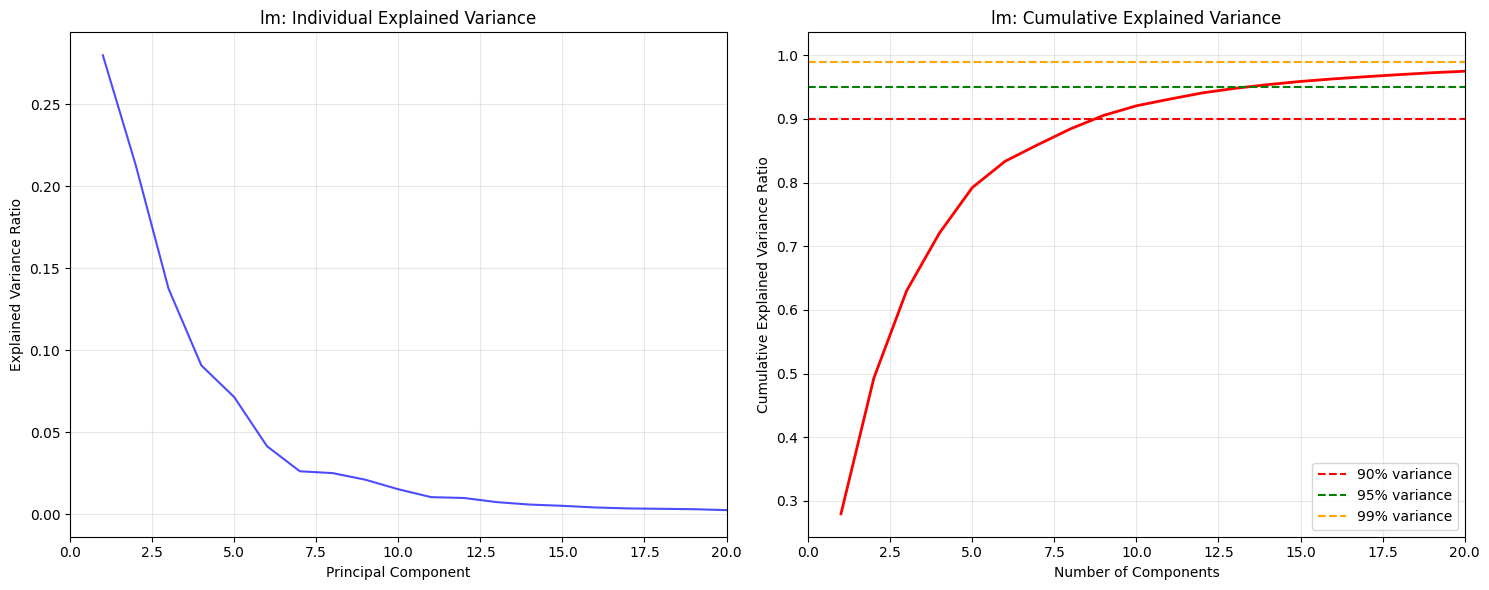

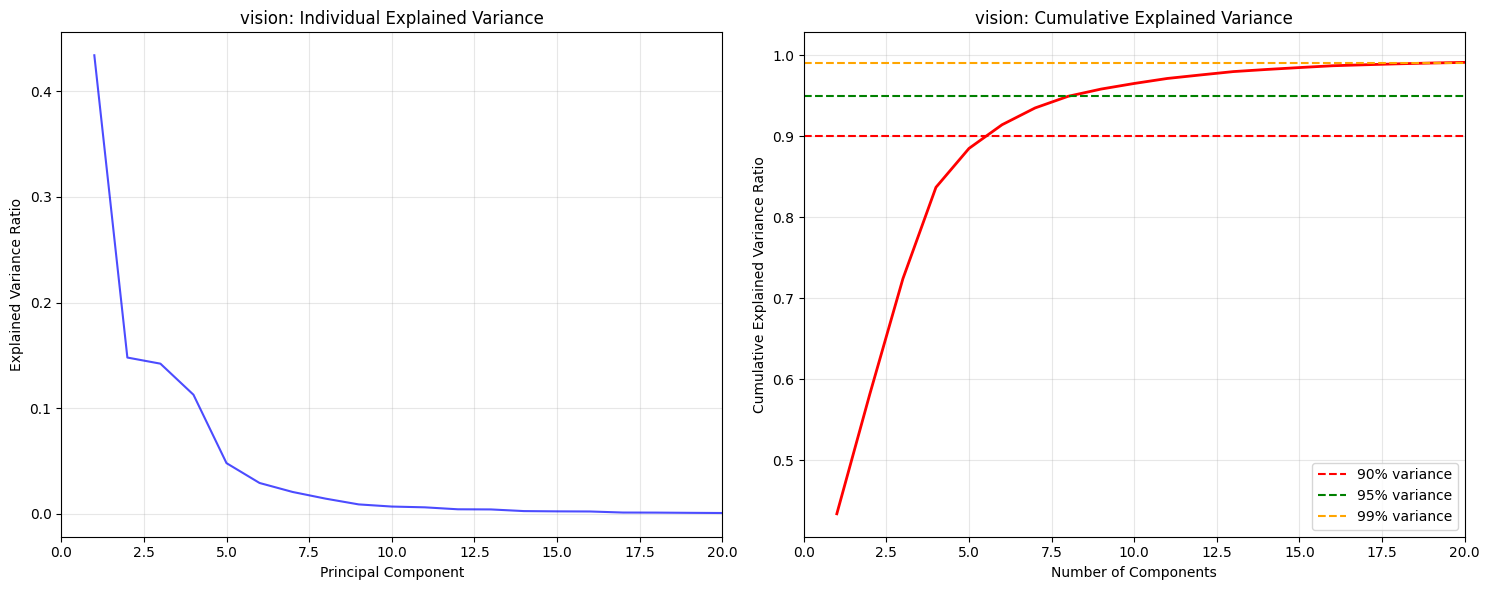

In [10]:

# Visualize PCA results
def plot_pca_variance(pca_results, embedding_name):
    """Plot explained variance for PCA"""
    if embedding_name not in pca_results or pca_results[embedding_name] is None:
        return
    
    result = pca_results[embedding_name]
    explained_var = result['explained_variance_ratio']
    cumulative_var = result['cumulative_variance']
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Individual explained variance
    ax1.plot(range(1, min(51, len(explained_var) + 1)), explained_var[:50], 'b-', alpha=0.7)
    ax1.set_xlabel('Principal Component')
    ax1.set_ylabel('Explained Variance Ratio')
    ax1.set_title(f'{embedding_name}: Individual Explained Variance')
    ax1.set_xlim(0, 20)
    ax1.grid(True, alpha=0.3)
    
    # Cumulative explained variance
    ax2.plot(range(1, len(cumulative_var) + 1), cumulative_var, 'r-', linewidth=2)
    ax2.axhline(y=0.90, color='red', linestyle='--', label='90% variance')
    ax2.axhline(y=0.95, color='g', linestyle='--', label='95% variance')
    ax2.axhline(y=0.99, color='orange', linestyle='--', label='99% variance')
    ax2.set_xlabel('Number of Components')
    ax2.set_ylabel('Cumulative Explained Variance Ratio')
    ax2.set_title(f'{embedding_name}: Cumulative Explained Variance')
    ax2.legend()
    ax2.set_xlim(0, 20)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Plot PCA variance for all embedding types
for emb_type in ['lm', 'vision', 'lens']:
    if emb_type in pca_results:
        plot_pca_variance(pca_results, emb_type)


In [71]:
# t-SNE Analysis for all embedding types
def perform_tsne_analysis(embedding_matrix, color_metadata, embedding_name, perplexity=7, n_iter=5000):
    """Perform t-SNE analysis and return results"""
    if embedding_matrix is None:
        print(f"No data available for {embedding_name}")
        return None
    
    print(f"\n=== t-SNE Analysis for {embedding_name} ===")
    print(f"Input shape: {embedding_matrix.shape}")
    print(f"Perplexity: {perplexity}")
    
    # Standardize the data
    scaler = StandardScaler()
    embedding_matrix_scaled = scaler.fit_transform(embedding_matrix)
    
    # Perform t-SNE
    tsne = TSNE(n_components=2, perplexity=perplexity, max_iter=n_iter, random_state=42, verbose=1, min_grad_norm=1e-8, n_iter_without_progress=1000)
    tsne_result = tsne.fit_transform(embedding_matrix_scaled)
    
    print(f"t-SNE completed. Final KL divergence: {tsne.kl_divergence_:.3f}")
    
    return {
        'tsne_result': tsne_result,
        'tsne_model': tsne,
        'scaler': scaler
    }

# Perform t-SNE for each embedding type
tsne_results = {}
if lm_matrix is not None:
    tsne_results['lm'] = perform_tsne_analysis(lm_matrix, lm_color_meta, "LM Pooled Mean")
if vision_matrix is not None:
    tsne_results['vision'] = perform_tsne_analysis(vision_matrix, vision_color_meta, "Vision Pooled Mean")



=== t-SNE Analysis for LM Pooled Mean ===
Input shape: (32, 3584)
Perplexity: 7
[t-SNE] Computing 22 nearest neighbors...
[t-SNE] Indexed 32 samples in 0.000s...
[t-SNE] Computed neighbors for 32 samples in 0.047s...
[t-SNE] Computed conditional probabilities for sample 32 / 32
[t-SNE] Mean sigma: 33.724272


[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.176132
[t-SNE] KL divergence after 5000 iterations: 0.108445
t-SNE completed. Final KL divergence: 0.108

=== t-SNE Analysis for Vision Pooled Mean ===
Input shape: (32, 3584)
Perplexity: 7
[t-SNE] Computing 22 nearest neighbors...
[t-SNE] Indexed 32 samples in 0.000s...
[t-SNE] Computed neighbors for 32 samples in 0.023s...
[t-SNE] Computed conditional probabilities for sample 32 / 32
[t-SNE] Mean sigma: 34.178611
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.661354
[t-SNE] KL divergence after 2550 iterations: 0.167894
t-SNE completed. Final KL divergence: 0.168


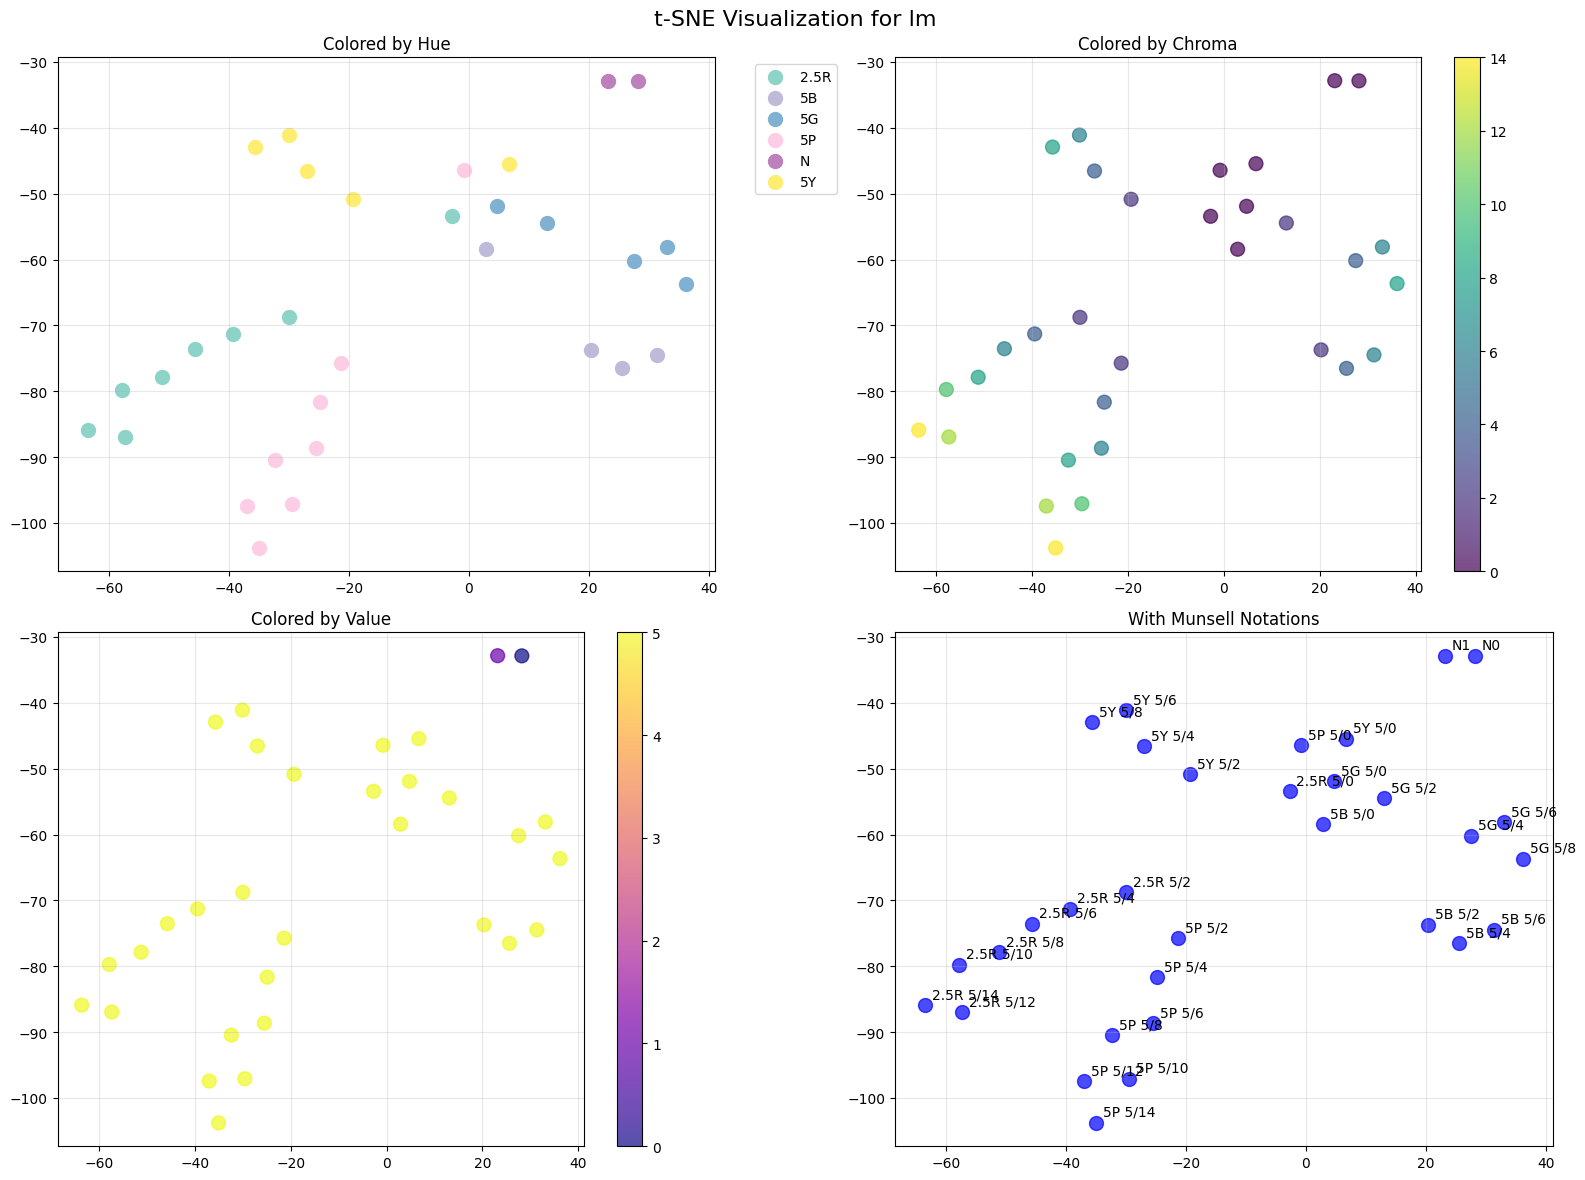

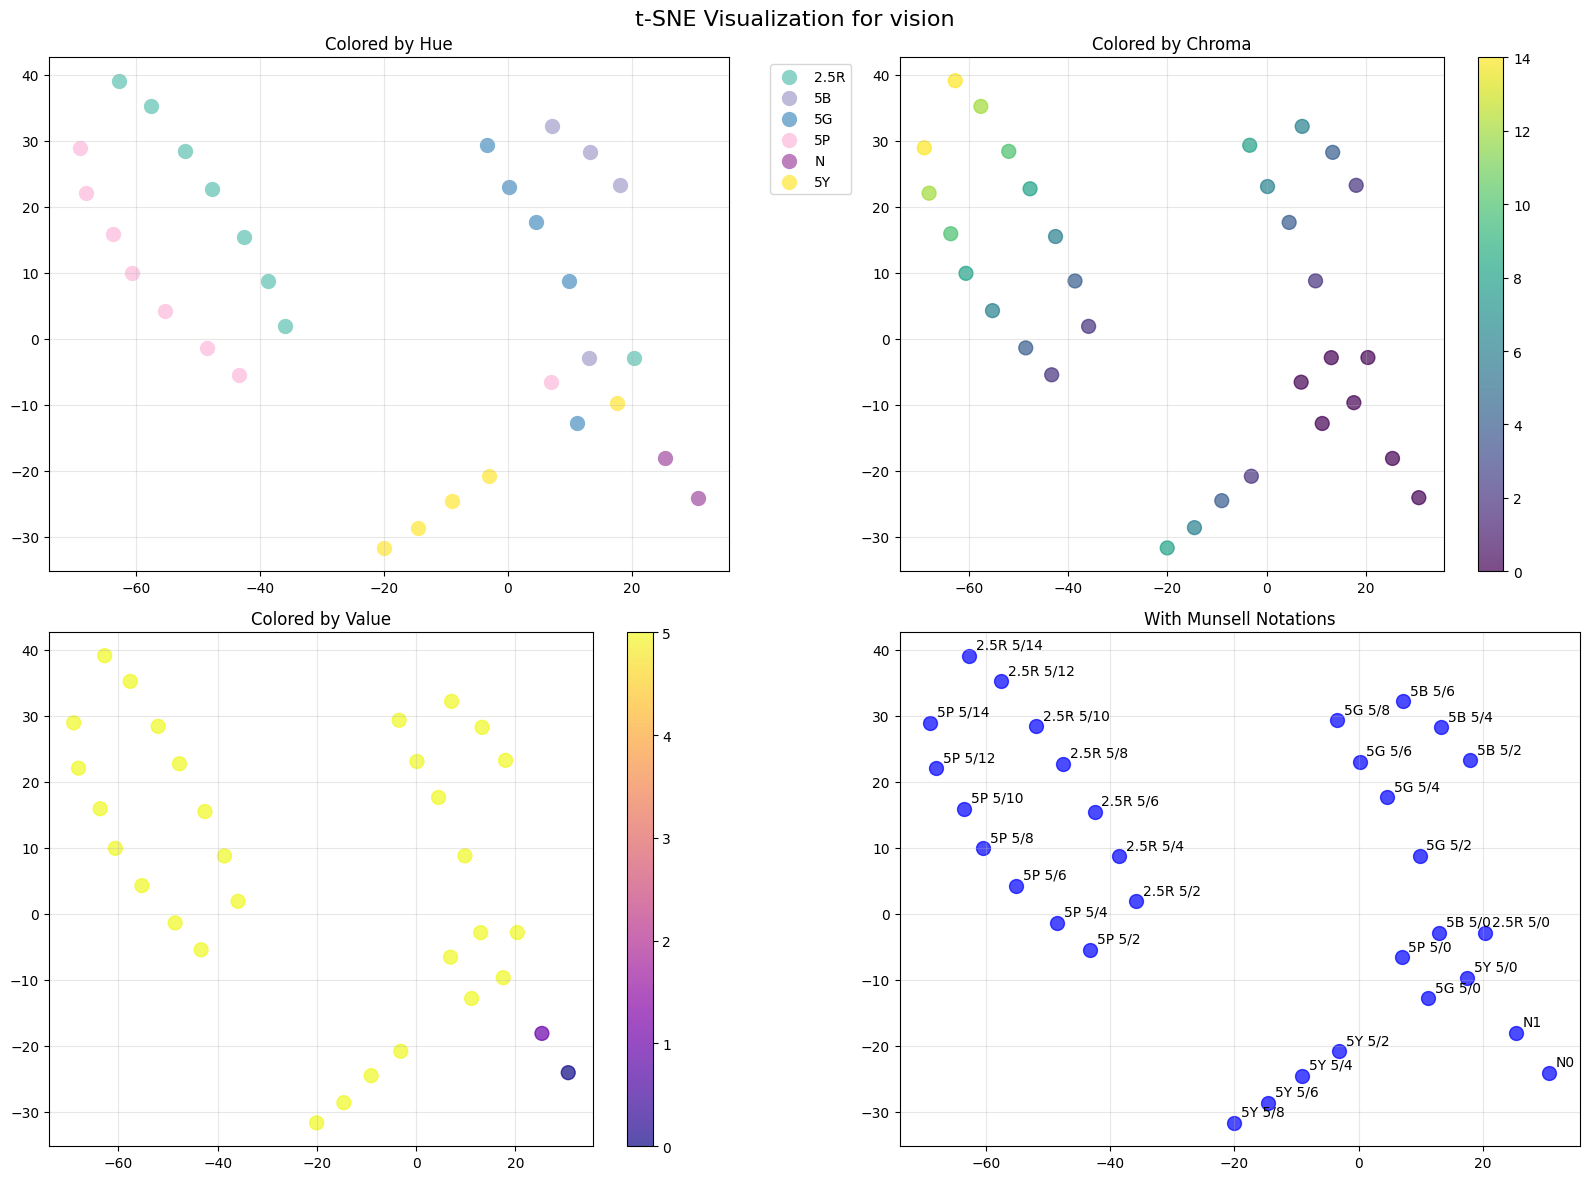

In [72]:
# Visualize t-SNE results with color information
def plot_tsne_results(tsne_results, color_metadata, embedding_name):
    """Plot t-SNE results colored by different color attributes"""
    if embedding_name not in tsne_results or tsne_results[embedding_name] is None:
        return
    
    tsne_result = tsne_results[embedding_name]['tsne_result']
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f't-SNE Visualization for {embedding_name}', fontsize=16)
    
    # Extract color information
    hues = [meta.get('H', 'Unknown') for meta in color_metadata]
    chromas = [meta.get('C', 0) for meta in color_metadata]
    values = [meta.get('V', 0) for meta in color_metadata]
    notations = [meta.get('notation', 'Unknown') for meta in color_metadata]
    
    # Plot 1: Colored by Hue
    unique_hues = list(set(hues))
    hue_colors = plt.cm.Set3(np.linspace(0, 1, len(unique_hues)))
    hue_color_map = {hue: hue_colors[i] for i, hue in enumerate(unique_hues)}
    
    for hue in unique_hues:
        mask = [h == hue for h in hues]
        axes[0,0].scatter(tsne_result[mask, 0], tsne_result[mask, 1], 
                         c=[hue_color_map[hue]], label=hue, alpha=1, s=100)
    axes[0,0].set_title('Colored by Hue')
    axes[0,0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[0,0].grid(True, alpha=0.3)
    
    # Plot 2: Colored by Chroma
    scatter = axes[0,1].scatter(tsne_result[:, 0], tsne_result[:, 1], 
                               c=chromas, cmap='viridis', alpha=0.7, s=100)
    axes[0,1].set_title('Colored by Chroma')
    plt.colorbar(scatter, ax=axes[0,1])
    axes[0,1].grid(True, alpha=0.3)
    
    # Plot 3: Colored by Value
    scatter = axes[1,0].scatter(tsne_result[:, 0], tsne_result[:, 1], 
                               c=values, cmap='plasma', alpha=0.7, s=100)
    axes[1,0].set_title('Colored by Value')
    plt.colorbar(scatter, ax=axes[1,0])
    axes[1,0].grid(True, alpha=0.3)
    
    # Plot 4: All points with notation labels
    axes[1,1].scatter(tsne_result[:, 0], tsne_result[:, 1], 
                     c='blue', alpha=0.7, s=100)
    # Add notation labels
    for i, notation in enumerate(notations):
        axes[1,1].annotate(notation, (tsne_result[i, 0], tsne_result[i, 1]), 
                          xytext=(5, 5), textcoords='offset points', fontsize=10)
    axes[1,1].set_title('With Munsell Notations')
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Plot t-SNE results for all embedding types
for emb_type in ['lm', 'vision', 'lens']:
    if emb_type in tsne_results:
        color_meta = {'lm': lm_color_meta, 'vision': vision_color_meta, 'lens': lens_color_meta}[emb_type]
        plot_tsne_results(tsne_results, color_meta, emb_type)


In [11]:
# Visualize PCA results in 2D
def plot_pca_2d(pca_results, color_metadata, embedding_name):
    """Plot first 2 PCA components colored by color attributes"""
    if embedding_name not in pca_results or pca_results[embedding_name] is None:
        return
    
    pca_result = pca_results[embedding_name]['pca_result']
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'PCA Visualization for {embedding_name} (First 2 Components)', fontsize=16)
    
    # Extract color information
    hues = [meta.get('H', 'Unknown') for meta in color_metadata]
    chromas = [meta.get('C', 0) for meta in color_metadata]
    values = [meta.get('V', 0) for meta in color_metadata]
    notations = [meta.get('notation', 'Unknown') for meta in color_metadata]
    
    # Plot 1: Colored by Hue
    unique_hues = list(set(hues))
    hue_colors = plt.cm.Set3(np.linspace(0, 1, len(unique_hues)))
    hue_color_map = {hue: hue_colors[i] for i, hue in enumerate(unique_hues)}
    
    for hue in unique_hues:
        mask = [h == hue for h in hues]
        axes[0,0].scatter(pca_result[mask, 0], pca_result[mask, 1], 
                         c=[hue_color_map[hue]], label=hue, alpha=0.7, s=50)
    axes[0,0].set_title('Colored by Hue')
    axes[0,0].set_xlabel(f'PC1 ({pca_results[embedding_name]["explained_variance_ratio"][0]:.3f})')
    axes[0,0].set_ylabel(f'PC2 ({pca_results[embedding_name]["explained_variance_ratio"][1]:.3f})')
    axes[0,0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[0,0].grid(True, alpha=0.3)
    
    # Plot 2: Colored by Chroma
    scatter = axes[0,1].scatter(pca_result[:, 0], pca_result[:, 1], 
                               c=chromas, cmap='viridis', alpha=0.7, s=50)
    axes[0,1].set_title('Colored by Chroma')
    axes[0,1].set_xlabel(f'PC1 ({pca_results[embedding_name]["explained_variance_ratio"][0]:.3f})')
    axes[0,1].set_ylabel(f'PC2 ({pca_results[embedding_name]["explained_variance_ratio"][1]:.3f})')
    plt.colorbar(scatter, ax=axes[0,1])
    axes[0,1].grid(True, alpha=0.3)
    
    # Plot 3: Colored by Value
    scatter = axes[1,0].scatter(pca_result[:, 0], pca_result[:, 1], 
                               c=values, cmap='plasma', alpha=0.7, s=50)
    axes[1,0].set_title('Colored by Value')
    axes[1,0].set_xlabel(f'PC1 ({pca_results[embedding_name]["explained_variance_ratio"][0]:.3f})')
    axes[1,0].set_ylabel(f'PC2 ({pca_results[embedding_name]["explained_variance_ratio"][1]:.3f})')
    plt.colorbar(scatter, ax=axes[1,0])
    axes[1,0].grid(True, alpha=0.3)
    
    # Plot 4: All points with notation labels
    axes[1,1].scatter(pca_result[:, 0], pca_result[:, 1], 
                     c='blue', alpha=0.7, s=50)
    # Add notation labels
    for i, notation in enumerate(notations):
        axes[1,1].annotate(notation, (pca_result[i, 0], pca_result[i, 1]), 
                          xytext=(5, 5), textcoords='offset points', fontsize=8)
    axes[1,1].set_title('With Munsell Notations')
    axes[1,1].set_xlabel(f'PC1 ({pca_results[embedding_name]["explained_variance_ratio"][0]:.3f})')
    axes[1,1].set_ylabel(f'PC2 ({pca_results[embedding_name]["explained_variance_ratio"][1]:.3f})')
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Plot PCA 2D results for all embedding types
for emb_type in ['lm', 'vision', 'lens']:
    if emb_type in pca_results:
        color_meta = {'lm': lm_color_meta, 'vision': vision_color_meta, 'lens': lens_color_meta}[emb_type]
        plot_pca_2d(pca_results, color_meta, emb_type)


NameError: name 'lm_color_meta' is not defined

## Analyze embeddings of similar grey color.

In [67]:

# Analysis of Same Colors (C=0, V=5)
# All colors with C=0 and V=5 are the same grey color but with different hues
# We want to analyze the variance and cosine angles of their embeddings

print("=" * 80)
print("SAME COLOR ANALYSIS (C=0, V=5)")
print("=" * 80)

# Identify same color samples (C=0, V=5)
same_color_indices = []
same_color_metadata = []

for i, meta in enumerate(lm_color_meta):
    if meta.get('C') == 0 and meta.get('V') == 5:
        same_color_indices.append(i)
        same_color_metadata.append(meta)
        print(f"Found same color: {meta.get('notation', 'Unknown')} (H={meta.get('H', 'Unknown')})")

print(f"\nTotal same color samples found: {len(same_color_indices)}")

if len(same_color_indices) < 2:
    print("Not enough same color samples for analysis")
else:
    # Extract embeddings for same color samples
    same_color_lm = lm_matrix[same_color_indices]
    same_color_vision = vision_matrix[same_color_indices]
    
    print(same_color_lm[0][1]*1000, same_color_lm[1][1]*1000)
    
    print(f"\nSame color embedding shapes:")
    print(f"  LM embeddings: {same_color_lm.shape}")
    print(f"  Vision embeddings: {same_color_vision.shape}")
    
    # Calculate variance within same color embeddings
    def calculate_embedding_variance(embeddings, embedding_name):
        """Calculate variance statistics for embeddings"""
        print(f"\n=== {embedding_name} Variance Analysis ===")
        
        # Calculate variance across samples (axis=0)
        sample_variance = np.var(same_color_lm, axis=0)
        mean_variance = np.mean(sample_variance)
        std_variance = np.std(sample_variance)
        
        # Calculate pairwise distances between all samples
        pairwise_distances = []
        for i in range(len(same_color_indices)):
            for j in range(i+1, len(same_color_indices)):
                dist = np.linalg.norm(embeddings[i] - embeddings[j])
                pairwise_distances.append(dist)
        
        pairwise_distances = np.array(pairwise_distances)
        
        # Calculate cosine similarities between all samples
        cosine_similarities = []
        for i in range(len(same_color_indices)):
            for j in range(i+1, len(same_color_indices)):
                # Normalize vectors
                vec_i = embeddings[i] / np.linalg.norm(embeddings[i])
                vec_j = embeddings[j] / np.linalg.norm(embeddings[j])
                cosine_sim = np.dot(vec_i, vec_j)
                cosine_similarities.append(cosine_sim)
        
        cosine_similarities = np.array(cosine_similarities)
        
        print(f"Variance Statistics:")
        print(f"  Mean variance across dimensions: {mean_variance:.6f}")
        print(f"  Std variance across dimensions: {std_variance:.6f}")
        print(f"  Min variance: {np.min(sample_variance):.6f}")
        print(f"  Max variance: {np.max(sample_variance):.6f}")
        
        print(f"\nPairwise Distance Statistics:")
        print(f"  Mean pairwise distance: {np.mean(pairwise_distances):.6f}")
        print(f"  Std pairwise distance: {np.std(pairwise_distances):.6f}")
        print(f"  Min pairwise distance: {np.min(pairwise_distances):.6f}")
        print(f"  Max pairwise distance: {np.max(pairwise_distances):.6f}")
        
        print(f"\nCosine Similarity Statistics:")
        print(f"  Mean cosine similarity: {np.mean(cosine_similarities):.6f}")
        print(f"  Std cosine similarity: {np.std(cosine_similarities):.6f}")
        print(f"  Min cosine similarity: {np.min(cosine_similarities):.6f}")
        print(f"  Max cosine similarity: {np.max(cosine_similarities):.6f}")
        
        # Calculate angles in degrees
        angles_degrees = np.arccos(np.clip(cosine_similarities, -1, 1)) * 180 / np.pi
        print(f"\nAngle Statistics (degrees):")
        print(f"  Mean angle: {np.mean(angles_degrees):.2f}°")
        print(f"  Std angle: {np.std(angles_degrees):.2f}°")
        print(f"  Min angle: {np.min(angles_degrees):.2f}°")
        print(f"  Max angle: {np.max(angles_degrees):.2f}°")
        
        return {
            'sample_variance': sample_variance,
            'mean_variance': mean_variance,
            'pairwise_distances': pairwise_distances,
            'cosine_similarities': cosine_similarities,
            'angles_degrees': angles_degrees
        }
    
    # Analyze LM embeddings
    lm_variance_stats = calculate_embedding_variance(same_color_lm, "LM Pooled Mean")
    
    # Analyze Vision embeddings  
    vision_variance_stats = calculate_embedding_variance(same_color_vision, "Vision Pooled Mean")


SAME COLOR ANALYSIS (C=0, V=5)
Found same color: 5Y 5/0 (H=5Y)
Found same color: 5B 5/0 (H=5B)
Found same color: 5G 5/0 (H=5G)
Found same color: 5P 5/0 (H=5P)
Found same color: 2.5R 5/0 (H=2.5R)

Total same color samples found: 5
7187.5 7187.5

Same color embedding shapes:
  LM embeddings: (5, 3584)
  Vision embeddings: (5, 3584)

=== LM Pooled Mean Variance Analysis ===
Variance Statistics:
  Mean variance across dimensions: 0.000000
  Std variance across dimensions: 0.000000
  Min variance: 0.000000
  Max variance: 0.000000

Pairwise Distance Statistics:
  Mean pairwise distance: 0.000000
  Std pairwise distance: 0.000000
  Min pairwise distance: 0.000000
  Max pairwise distance: 0.000000

Cosine Similarity Statistics:
  Mean cosine similarity: 1.000000
  Std cosine similarity: 0.000000
  Min cosine similarity: 1.000000
  Max cosine similarity: 1.000000

Angle Statistics (degrees):
  Mean angle: 0.00°
  Std angle: 0.00°
  Min angle: 0.00°
  Max angle: 0.00°

=== Vision Pooled Mean Va